<table class="tfo-notebook-buttons" align="left">
<!--   <td>
    <a target="_blank" href="https://www.infocusp.com/home"><img src="https://www.infocusp.in/static/media/logo2.2b25740fa600fe779f23c6cf86e678b1.svg" width=100 />Infocusp</a>
  </td> -->
<!--   <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1e8fQCnPVcEmT9Rdr2hu87qz120VqnJ97?authuser=1#scrollTo=C0EVLOt8MwG1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td> -->
  <td>
    <a target="_blank" href="https://github.com/InFoCusp/diffusion_models"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View original source on GitHub</a>
  </td>
</table>

Author: Falak Shah, Infocusp Innovations Private Limited

Translated from TensorFlow to PyTorch and modified by Roman Remme

# Hands on Diffusion model

[Diffusion models](https://arxiv.org/pdf/2006.11239.pdf) are a family of models that have shown amazing capability of generating photorealistic images with/ without text prompt. They have two flows as shown in the figure below - 
1. Deterministic forward flow (from image to noise) and 
2. Generative reverse flow (recreating image from noise).

Diffusion models get their name from the forward flow where they follow a markov chain of diffusion steps, each of which adds a small amount of random noise to the data. Then they learn the model to reverse the diffusion process and construct desired data samples from noise. 

<figure>
<p style="text-align:center;"  align = "center"><img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/Fixed_Forward_Diffusion_Process.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">Forward and reverse process <a href="https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/">Ref: Nvidia blog</a> </figcaption>
</figure>
 


Since they map noise to data, these models can be said to be capable of learning the distributions that generate data of any particular domain.

This notebook showcases a minimal example of the forward diffusion process and its reverse mapping using a dense network. It is meant to give the reader side by side code snippets to match the equations in the paper and visual examples of the complete process.

### Imports and utility functions

In [1]:
#@title

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import display
import functools
import sklearn.datasets
from tqdm.auto import tqdm
# For plotting
from IPython.display import HTML
from base64 import b64encode

In [3]:
#@title
# Utility function for displaying video inline

def show_video(vname):
    mp4 = open(vname,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))

def save_animation(vname, interval=30):
    anim = camera.animate(blit=True, interval=interval)
    anim.save(vname)
    plt.close()

# Utility function for random noise
def noise_like(shape):
    return torch.randn_like(shape=shape)

## Data distribution

Images can be thought of as points sampled from $height \times width$ dimensional space. 

Consider an image of dimension $height \times width$. Then the total number of pixels are $height \times width$. Each pixel has a value ranging from 0 to 255.
Now, consider a vector space, where we flatten this image and represent the intensity of each pixel along one dimension of the vector space. For example, an image with $height = 2$ and $ width =3$ (2px x 3px image) becomes a single vector of length 6 where each component of this vector will have a value between 0 to 255.

So, in this image vector space, there are small clusters of valid (photorealistic) images sparsely distributed over the space. Rest of the vector space is made up of invalid (not real looking) images.


For the example in this notebook, we consider a **hypothetical** simplified version of the above representation. We consider images made of just 2 pixels, each of which can have values between [-5, 5]. This is to allow visualization of each dimension of the data as it moves through the forward and reverse process (and additionally faster training 😅). 

The same code can be extended to the original image dimensions with just updated data dimensions.

In [4]:
# Evaluate to generate and use gaussian mixture dataset
# Generate original points which are around [0.5, 0.5] in all quadrants and 
# 4 corners ([0,1], [1,0], [0,-1], [-1, 0])
# Some region around these points indicates valid images region (true data distribution)

num_samples_per_center = 1000
stddev = 0.1
mean = 0

centers = torch.tensor([[0,1], [1,0], [0,-1], [-1, 0],
                    [0.5, 0.5], [0.5, -0.5], [-0.5, -0.5], 
                    [-0.5,0.5]]) * 4
print(centers)
all_data = []
# Data for all clusters
for center in centers:
    center_data = torch.randn(size=(num_samples_per_center, 2)) * stddev + center
    all_data.append(center_data)

train_data = torch.cat(all_data, dim=0)

train_data -= train_data.mean(0, keepdims=True)
train_data /= train_data.std(0, keepdims=True)
print(f'{train_data.shape[0]} samples of {train_data.shape[1]} dimensions in training data')

tensor([[ 0.,  4.],
        [ 4.,  0.],
        [ 0., -4.],
        [-4.,  0.],
        [ 2.,  2.],
        [ 2., -2.],
        [-2., -2.],
        [-2.,  2.]])
8000 samples of 2 dimensions in training data


In [5]:
# Evaluate to generate and use V-Shaped dataset

num_samples_per_center = 4000
stddev = 0.1

def sample_along_line(p1, p2, n):
    t = torch.rand(n, dtype=torch.float32)[:, None]
    return p1[None] * t + p2[None] * (1-t)

lines = torch.tensor([[[0, 0], [2, 3]], 
                      [[0, 0], [-2, 3]]])
train_data = torch.cat([sample_along_line(*line, num_samples_per_center) 
                        for line in lines])
train_data += torch.randn_like(train_data) * stddev
train_data -= train_data.mean(0, keepdims=True)
train_data /= train_data.std(0, keepdims=True)

print(f'{train_data.shape[0]} samples of {train_data.shape[1]} dimensions in training data')

8000 samples of 2 dimensions in training data


In [6]:
# Evaluate to generate and use two moons dataset

num_samples_per_center = 4000
train_data, labels = sklearn.datasets.make_moons(8000)
train_data = train_data[np.argsort(labels)] # sort by moon for plotting
train_data = torch.from_numpy(train_data).float()
train_data -= train_data.mean(0, keepdims=True)
train_data /= train_data.std(0, keepdims=True)

print(f'{train_data.shape[0]} samples of {train_data.shape[1]} dimensions in training data')

8000 samples of 2 dimensions in training data


The x's  in the plot below can be thought of as valid images in 2d space with the rest of the white region representing the rest of the invalid images. The blue clusters around the x's are also valid images (corresponding to minor pixel perturbations in original images).

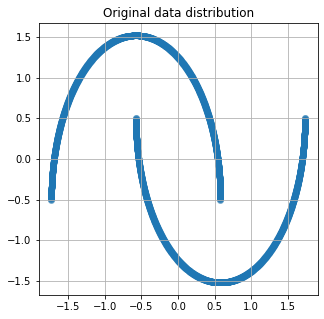

In [7]:
#@title
# Visualize the data
plt.figure(figsize=[5,5])
plt.scatter(train_data[:,0], train_data[:,1], alpha=0.1)
plt.title('Original data distribution')
plt.grid()

## Beta schedule

Now that we have the original (non noisy) data, let's start now with the actual diffusion implementation. The first thing is to add noise to the input images following a fixed variance schedule (also known as beta schedule). The original paper uses a linear schedule. And 1000 timesteps to move forward and back. We use smaller number of timesteps (250) as the data is simpler in our case.

In [8]:
num_diffusion_timesteps=250
beta_start = 0.0001
beta_end = 0.02
# schedule_type='linear'

def get_beta_schedule(schedule_type, beta_start, beta_end, num_diffusion_timesteps):
    if schedule_type == 'quadratic':
        betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float32) ** 2
    elif schedule_type == 'linear':
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32)
    elif schedule_type == 'cosine':
        # Implements eq. (17) and below from https://arxiv.org/pdf/2102.09672.pdf
        t = torch.arange(num_diffusion_timesteps)
        s = 0.008
        f = torch.cos((t / num_diffusion_timesteps + s) / (1 + s) * np.pi/2) ** 2
        alphas_cumprod = f / f[0]
        betas = 1 - alphas_cumprod / torch.cat([torch.ones(1), alphas_cumprod[:-1]])
        betas = betas.clip(max=0.999).numpy()
    return betas

betas_linear = get_beta_schedule('linear', beta_start, beta_end, num_diffusion_timesteps)
betas_quad = get_beta_schedule('quadratic', beta_start, beta_end, num_diffusion_timesteps)
betas_cosine = get_beta_schedule('cosine', beta_start, beta_end, num_diffusion_timesteps)

### Visualize beta schedules

The below plot shows that the variance of noise is low at the start and increases as we move forward in time.

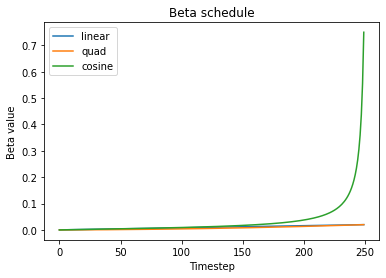

In [9]:
#@title
plt.plot(betas_linear, label = 'linear')
plt.plot(betas_quad, label='quad')
plt.plot(betas_cosine, label='cosine')
plt.title('Beta schedule')
plt.ylabel('Beta value')
plt.xlabel('Timestep')
plt.legend()

### Beta derivatives

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/ compute.

We'll see the use cases of these variables in the respective sections below.

In [10]:
class BetaDerivatives():
    def __init__(self, betas, dtype=torch.float32):
        """Take in betas and pre-compute the dependent values to use in forward/ backward pass.

        Values are precomputed for all timesteps so that they can be used as and
        when required.
        """
        self.np_betas = betas
        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        self.betas = torch.from_numpy(betas).to(dtype=dtype)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = self.alphas.cumprod(dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.ones(1), self.alphas_cumprod[:-1]], dim=0)

        # calculations required for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1. - self.alphas_cumprod)


In [11]:
gdb = BetaDerivatives(betas_linear)

### Visualize beta derivatives over time

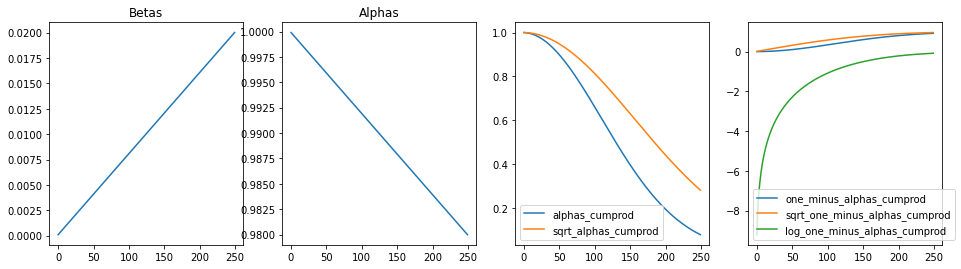

In [12]:
#@title
# Visualizing betas and other variables
plt.figure(figsize=(16, 9))

plt.subplot(2,4,1)
plt.plot(gdb.betas)
plt.title('Betas')
plt.subplot(2,4,2)
plt.plot(gdb.alphas)
plt.title('Alphas')

plt.subplot(2,4,3)
plt.plot(gdb.alphas_cumprod, label='alphas_cumprod')
plt.plot(gdb.sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.legend();
plt.subplot(2,4,4)
plt.plot(1-gdb.alphas_cumprod, label='one_minus_alphas_cumprod')
plt.plot(gdb.sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod')
plt.plot(gdb.log_one_minus_alphas_cumprod, label='log_one_minus_alphas_cumprod')
plt.legend();

## Forward pass of diffusion model

In the forward pass, the diffused input at timestep t can be computed directly using the closed form equation (For derivation of how we arrive at this, refer to the paper).

$q(x_t| x_0) = N(\sqrt{\bar{\alpha_t}}x_o, 1-\bar{\alpha_t}I)$

This is done in the q_sample function below. 

In [13]:
class DiffusionForward(BetaDerivatives):
    """
    Forward pass of the diffusion model.
    """

    def __init__(self, betas):
        super().__init__(betas)


    def q_sample(self, x_start, t, noise=None):
        """
        Forward pass - sample of diffused data at time t.
        """
        if noise is None:
          noise = torch.randn(x_start.shape)
        p1 = self.sqrt_alphas_cumprod[t] * x_start 
        p2 = self.sqrt_one_minus_alphas_cumprod[t] * noise 
        return (p1 + p2)

    def q_sample_step(self, x_t, t, noise=None):
        """
        Single step of forward diffusion, samples from p(x_(t+1)|x_t)
        """
        noise = torch.randn(x_t.shape) if noise is None else noise
        p1 = torch.sqrt(1 - self.betas[t]) * x_t
        p2 = torch.sqrt(self.betas[t]) * noise
        return p1 + p2

diff_forward = DiffusionForward(betas_linear)

### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after num_diffusion_steps. 

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.

In [14]:
#@title

camera = Camera(plt.figure())
stepsize = 10
x0 = train_data[:]
for timestep in tqdm(range(0, num_diffusion_timesteps, stepsize)): 
    tstep = torch.ones_like(x0[0], dtype=torch.long) * timestep
    shifted = diff_forward.q_sample(x0, tstep)
    order = np.arange(len(x0)).astype(np.int32)
    np.random.shuffle(order)
    plt.scatter(shifted[order,0], shifted[order,1], 
              marker='.',
              c=np.arange(x0.shape[0])[order]//num_samples_per_center, 
              alpha=0.1)
    plt.gca().annotate(
        f'Time step: {timestep}', xy=(5, 5), xycoords='axes points',
        size=14, ha='left', va='bottom'
    )
    camera.snap()

save_animation('scatter.mp4',  stepsize)
show_video('scatter.mp4')

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
xt = train_data[:]
xt = xt[4000,:]
xt,diff_forward.q_sample_step(xt, 10)

(tensor([ 1.0849, -1.3117]), tensor([ 1.0566, -1.2797]))

In [16]:
# same as above, but with single diffusion steps p(x_t|x_t-1), 
# instead of sampling from p(x_t|x_0) for every frame

camera = Camera(plt.figure())

xt = train_data[:]

stepsize = 10

# order for plotting the points
order = np.arange(len(x0)).astype(np.int32)
np.random.shuffle(order)

for timestep in tqdm(range(0, num_diffusion_timesteps+1)): 
    if timestep > 0:
        tstep = torch.ones_like(x0[0], dtype=torch.long) * (timestep - 1)
        xt = diff_forward.q_sample_step(xt, tstep)
    if timestep % 5 == 0:
        plt.scatter(xt[order, 0], xt[order, 1], 
                    marker='.',
                    c=np.arange(x0.shape[0])[order] // num_samples_per_center, 
                    alpha=0.1)
        plt.gca().annotate(
            f'Time step: {timestep}', xy=(5, 5), xycoords='axes points',
                  size=14, ha='left', va='bottom')
        camera.snap()

save_animation('scatter.mp4', 150)
show_video('scatter.mp4')

  0%|          | 0/251 [00:00<?, ?it/s]

### Visualize the forward pass of single point

We perform the forward diffusion of a single point over time. At every timestep, we generate 500 possible diffused samples of the same input point. We observe the distribution of these points over time. 

These too are closer to the original point at the start and move towards gaussian as the forward process reaches num_timesteps same as the example above.

tensor([[ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1.3145],
        [ 1.1681, -1

In [17]:
#@title
camera = Camera(plt.figure())

x0 = torch.tensor([[0.0,4.0]]).repeat((500, 1))
for timestep in range(0, num_diffusion_timesteps, 10): 
    tstep = torch.ones_like(x0[0], dtype=torch.long) * timestep
    shifted = diff_forward.q_sample(x0, tstep)
    plt.scatter(shifted[:, 0], shifted[:, 1], c='b')
    plt.scatter(x0[0,0], x0[0,1], marker='x', c='r')
    camera.snap()

save_animation('pointshifting.mp4', 300)
show_video('pointshifting.mp4')

## Model building

With the data taken care of, let's build a model that can fit the data. We use a DNN with few layers since we're just using data with 2 features that we wish to reconstruct. Would be replaced with unet with similar loss function for the case of image data.

The model takes in 2 inputs:
* Timestep embedding of $t$
* $x_t$

And predicts 
* The noise $n$ that lead from $x_0$ to $x_t$

### Timestep embedding

In [18]:
# We create a 128 dimensional embedding for the timestep input to the model. 
# Fixed embeddings similar to positional embeddings in transformer are used - 
# could be replaced by trainable embeddings later
emb_size = 128

def get_timestep_embedding(timesteps, embedding_dim: int):
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.pad(emb, [[0, 0], [0, 1]])
    return emb

# test on an example
temb = get_timestep_embedding(torch.tensor([2, 3]), emb_size)
print(temb.shape)

torch.Size([2, 128])


In [19]:
# Actual model that takes in x_t and t and outputs n_{t-1}
# Experiments showed that prediction of n_{t-1} worked better compared to
# prediction of x_{t-1}
from torchvision.ops import MLP
from torch.optim import Adam

class DiffusionModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.x_emb = torch.nn.Linear(in_channels, emb_size)
        self.mlp = MLP(
            in_channels=emb_size * 2, 
            hidden_channels=[128, 64, 32, 16, 2], 
            activation_layer=torch.nn.ELU,
        )

    def forward(self, x, temb):
        # inpute embedding
        x = self.x_emb(x)
        # concatenate timestep embedding
        x = torch.cat([temb, x], dim=1)
        # main MLP
        x = self.mlp(x)
        return x


### Data generation for diffusion model

Next, let's generate the data for the model to train. We generate $x_t$ given the input $x_0$ using the deterministic forward process equation described above. This $x_t$ and timestep embedding of 
$t$ are input to the model that is tasked with predicting the noise $n$.

$t$ is picked uniformly between [0, num_diffusion_timesteps]

In [20]:
128*62

7936

In [21]:
import torch

batch_size = 128

class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        # randomly sample timestep and noise
        tstep = torch.randint(0, num_diffusion_timesteps, (1,), dtype=torch.long)
        noise = torch.randn(self.data.shape[1])
        noisy_out = diff_forward.q_sample(self.data[i], tstep, noise)
        return ((noisy_out, get_timestep_embedding(tstep, emb_size)[0]), noise) 
    

class DiffusionDataloader(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def __getitem__(self, i):
        # randomly sample timestep and noise
        tstep = torch.randint(0, num_diffusion_timesteps, 
                              (self.batch_size,), dtype=torch.long)
        noise = torch.randn(self.batch_size, self.data.shape[1])
        # randomly sample subset of the data: 
        # this could be improved to not use duplicates during an epoch
        ind = torch.randint(0, self.data.shape[0], 
                              (self.batch_size,), dtype=torch.long)
        noisy_out = diff_forward.q_sample(self.data[ind], tstep[:, None], noise)
        return ((noisy_out, get_timestep_embedding(tstep, emb_size)), noise,tstep) 

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

            
# dataset = DiffusionDataset(train_data)
# dataloader = torch.utils.data.DataLoader(
#     dataset, 
#     shuffle=True, 
#     batch_size=batch_size,
#     drop_last=True,
# )

# Use the custom dataloader: it's much faster
dataloader = DiffusionDataloader(train_data, batch_size=batch_size)

128*62

7936

### Train and evaluate the model

DiffusionModel(
  (x_emb): Linear(in_features=2, out_features=128, bias=True)
  (mlp): MLP(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Dropout(p=0.0, inplace=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ELU(alpha=1.0, inplace=True)
    (5): Dropout(p=0.0, inplace=True)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ELU(alpha=1.0, inplace=True)
    (8): Dropout(p=0.0, inplace=True)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ELU(alpha=1.0, inplace=True)
    (11): Dropout(p=0.0, inplace=True)
    (12): Linear(in_features=16, out_features=2, bias=True)
    (13): Dropout(p=0.0, inplace=True)
  )
)


Training for 150 epochs..:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0/150. loss: 6.49e-01
Epoch 10/150. loss: 4.97e-01
Epoch 20/150. loss: 4.68e-01
Epoch 30/150. loss: 4.52e-01
Epoch 40/150. loss: 4.40e-01
Epoch 50/150. loss: 4.34e-01
Epoch 60/150. loss: 4.30e-01
Epoch 70/150. loss: 4.28e-01
Epoch 80/150. loss: 4.25e-01
Epoch 90/150. loss: 4.23e-01
Epoch 100/150. loss: 4.23e-01
Epoch 110/150. loss: 4.22e-01
Epoch 120/150. loss: 4.19e-01
Epoch 130/150. loss: 4.22e-01
Epoch 140/150. loss: 4.22e-01


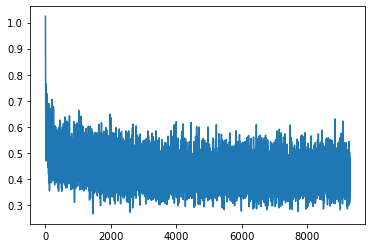

In [23]:
from tqdm.auto import tqdm

# device = torch.device('cuda:0')
device = torch.device('cpu')

model = DiffusionModel(in_channels=2)
print(model)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss().to(device)

num_epochs = 150
losses = []
for epoch in tqdm(range(num_epochs), desc=f'Training for {num_epochs} epochs..'):
    for iteration, ((x, temb), target,tst) in enumerate(dataloader):
        optimizer.zero_grad()
        target = target.to(device)
        x, temb = x.to(device), temb.to(device)
        pred = model(x, temb)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}. loss: {np.mean(losses[-len(dataloader) * 10:]):.2e}')
plt.plot(losses)
plt.show()

### Scatter plots of reconstructed values v/s target

In [ ]:
tst

In [107]:
temb

tensor([[ 0.9988,  0.8963, -0.9502,  ...,  0.9995,  0.9996,  0.9997],
        [ 0.2194,  0.0081,  0.0556,  ...,  0.9998,  0.9998,  0.9999],
        [ 0.8064,  0.2409,  0.8973,  ...,  0.9998,  0.9998,  0.9999],
        ...,
        [-0.9746,  0.8862,  0.1632,  ...,  0.9996,  0.9997,  0.9998],
        [ 0.9965, -0.9977, -0.8753,  ...,  0.9996,  0.9997,  0.9998],
        [-0.8979,  0.8070,  0.4749,  ...,  1.0000,  1.0000,  1.0000]])

In [24]:
# TODO: Create scatterplots between predicted and ground truth noise. Color the points by the diffusion timestep.


##predicted noise 

true_noise = torch.tensor([0,0]).reshape(1,2)
time_info  = torch.tensor([]) 
pred_noise = torch.tensor([0,0]).reshape(1,2)
for iteration, ((x, temb), target,tst) in enumerate(dataloader):
    if(iteration>10):
        break;
    x, temb,target = x.to(device), temb.to(device), target.to(device)
    pred = model(x, temb)
    pred_noise = torch.cat((pred_noise,pred))
    true  = (target)
    true_noise = torch.cat((true_noise,true))
    time_info = torch.cat((time_info,tst))
pred_noise = pred_noise.detach().numpy()
true_noise = true_noise.detach().numpy()

In [25]:
time = time_info.detach().numpy()

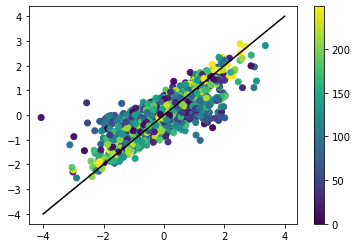

In [26]:

plt.figure()
pred_noise = np.delete(pred_noise,0,axis =0)
true_noise = np.delete(true_noise,0,axis =0)

plt.scatter(true_noise[:,0],pred_noise[:,0],c = time)
x = np.linspace(-4,4,100)
y = x
plt.colorbar()
plt.plot(x,y,c = 'k')
plt.show()

In [36]:
a = torch.rand((5,2))

torch.cat((a,a))

tensor([[0.0078, 0.2220],
        [0.4252, 0.9628],
        [0.9000, 0.0190],
        [0.8394, 0.6663],
        [0.9997, 0.7971],
        [0.0078, 0.2220],
        [0.4252, 0.9628],
        [0.9000, 0.0190],
        [0.8394, 0.6663],
        [0.9997, 0.7971]])

## Reverse process of diffusion

The model provides a decent estimate of the noise given the data and t.  Now comes the tricky part: given the data at timestep t $x_t$, and the noise estimate from the model, reconstructing original data distribution.


There are 4 parts in the reverse process: 
1. Pass $x_t$ and $t$ (converted to time embedding) into the model that predicts the noise $ϵ$ 
2. Using the noise estimate $ϵ$ and $x_t$, compute $x_0$ using equation : $\frac{1}{\sqrt{\bar{\alpha}_t}}x_t - (\sqrt{\frac{1}{\bar{\alpha}_t}-1}) \epsilon$


3. Compute mean and variance using the equations: 

$\tilde{\mu}(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha_t}}x_0 + \frac{\sqrt{\bar{\alpha}_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$ and
variance $\tilde{\beta}_t = \frac{(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\beta_t$

4. Sample using this mean and variance
$q(x_{t−1}|x_t, x_0)=N(x_{t−1}; \tilde{\mu}(x_t, x_0), \tilde{\beta}_tI)$

tensor([ 0.6102, -0.8538], dtype=torch.float64)

In [85]:
class DiffusionReconstruct(BetaDerivatives):
  
    def __init__(self, betas):
        super().__init__(betas)

        self.sqrt_recip_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / self.alphas_cumprod - 1)

        # calculations required for posterior q(x_{t-1} | x_t, x_0)
        # Variance choice corresponds to 2nd choice mentioned in the paper
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)  


        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = np.log(np.maximum(self.posterior_variance, 1e-20))
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def predict_start_from_noise(self, x_t, t, noise):
        """
        Reconstruct x_0 using x_t, t and noise. Uses deterministic process
        """
        return (
            self.sqrt_recip_alphas_cumprod[t, None] * x_t -
            self.sqrt_recipm1_alphas_cumprod[t, None] * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
        """
        posterior_mean = (
            self.posterior_mean_coef1[t, None] * x_start +
            self.posterior_mean_coef2[t, None] * x_t
        )
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_sample(self, model, x_t, t):
        """
        Sample from the model. This does 4 things
        * Predict the noise from the model using x_t and t
        * Create estimate of x_0 using x_t and noise (reconstruction)
        * Estimate of model mean and log_variance of x_{t-1} using x_0, x_t and t
        * Sample data (for x_{t-1}) using the mean and variance values
        """
        noise_pred = model(x_t, get_timestep_embedding(t, emb_size)).to(device) # Step 1
        x_recon = self.predict_start_from_noise(x_t, t=t, noise=noise_pred) # Step 2
        model_mean, model_log_variance = self.q_posterior(x_start=x_recon, x_t=x_t, t=t) # Step 3
        noise = torch.randn(x_t.shape)
        nonzero_mask = (t > 0).reshape(x_t.shape[0], 1) 
        return model_mean + torch.exp(0.5 * model_log_variance)[:, None] * noise * nonzero_mask # Step 4

    
    # TODO: implement for task (c)
    def p_sample_samenoise(self, model, x_t, t):
        raise NotImplementedError

    # TODO: implement for task (d)
    def p_sample_DDIM(self, model, x_t, t, eta=0):
        raise NotImplementedError


    def p_sample_loop_trajectory(self, model, shape=None, latents=None, method="p_sample"):
        """
        Generate the visualization of intermediate steps of the reverse of diffusion
        process.
        """
        method = getattr(self, method)

        t = self.num_timesteps - 1 
        if latents is None:
            latents = torch.randn(shape)
        if shape is None:
            shape = latents.shape
        assert latents.shape == shape, f'Shape mismatch: {latents.shape}!={shape}'

        imgs = latents[None]
        with torch.no_grad():
            while t >= 0:
                imgs = torch.cat(
                    [imgs, 
                     method(
                         model=model, x_t=imgs[-1],
                         t=torch.ones(shape[0], dtype=torch.long) * t).to(device)[None]
                     ]
                )
                t -= 1

        return imgs

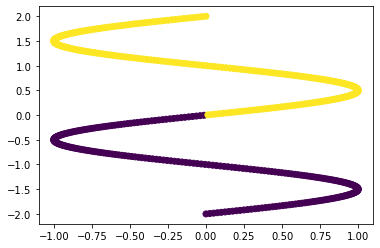

In [94]:

x = np.linspace(-2,0,500)
x = np.sin(2*np.pi*x).reshape(500,1)
y = np.linspace(-2,2,500).reshape(500,1)

c = np.zeros(500).reshape(500,1)
ind = np.where(y>0)
c[ind] = 1
lt_data = np.hstack((x,y))
plt.scatter(lt_data[:,0],lt_data[:,1],c = c)
lt_data = torch.tensor(lt_data,dtype = torch.float)
lt_data;

In [83]:
# TODO: use rec_diff.p_sample_loop_trajectory with different methods to visualize the reverse process on
#       points sampled from a gaussian and the linear interpolations as described on the sheet



rec_diff = DiffusionReconstruct(betas_linear)
rev_process_array = rec_diff.p_sample_loop_trajectory(model, shape=(1000,2))



RuntimeError: The size of tensor a (1000) must match the size of tensor b (500) at non-singleton dimension 0

tensor([[ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934],
        [ 1.5410, -0.2934]])

In [34]:
camera = Camera(plt.figure())
for timestep in tqdm(range(0, num_diffusion_timesteps+1)): 
    data =  rev_process_array[timestep]
    x = data[:,0].detach().numpy()
    y = data[:,1].detach().numpy()

    plt.scatter(x,y)

    camera.snap()

save_animation('scatter.mp4',25)
show_video('scatter.mp4')

  0%|          | 0/251 [00:00<?, ?it/s]

In [95]:
rec_diff = DiffusionReconstruct(betas_linear)
rev_process_array = rec_diff.p_sample_loop_trajectory(model,shape = (500,2),latents = lt_data)


In [96]:
camera = Camera(plt.figure())
for timestep in tqdm(range(0, 251)): 
    data2 =  rev_process_array[timestep]
    x1 = data2[:,0].detach().numpy()
    y1 = data2[:,1].detach().numpy()

    plt.scatter(x1,y1)    
    if(timestep%5==0):

        camera.snap()


save_animation('scatter.mp4')
show_video('scatter.mp4')

  0%|          | 0/251 [00:00<?, ?it/s]

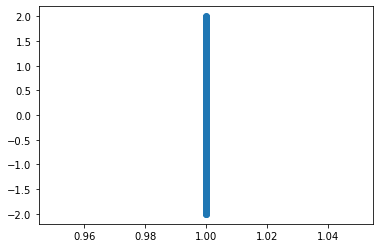

Sachin - I am currently working on application of Graph Neural Network implementation in particle track reconstruction problem for Atlas Inner Tracker which will be used for High Luminosity Large Hadron Collider. I have several Ideas in my brain for eg. using dimensionality reduction on actual data before training on graph neural nework to increase the purity and efficient performance.

References:
1. [Diffusion models repo](https://github.com/hojonathanho/diffusion)
2. [Diffusion models paper](https://arxiv.org/pdf/2006.11239.pdf)
3. [Improved Denoising Diffusion Probabilistic Models paper](https://arxiv.org/pdf/2102.09672.pdf)